多头注意力：多个头连结然后线性变换
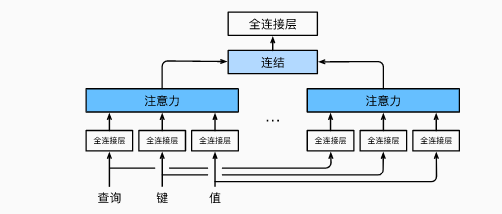

模型计算方式：
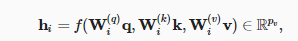

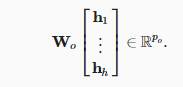

In [1]:
import math
import torch
from torch import nn
import dltools

In [6]:
# 具体实现
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = dltools.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:(batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:(batch_size*num_heads，查询或者“键－值”对的个数，num_hiddens/num_heads)
        print(queries.shape) # 2 4 100
        print(keys.shape) # 2 6 100
        print(values.shape) # 2 6 100
        queries = transpose_qkv(self.W_q(queries), self.num_heads) # 10 4 20
        keys = transpose_qkv(self.W_k(keys), self.num_heads) # 10 6 20
        values = transpose_qkv(self.W_v(values), self.num_heads) # 10 6 20

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，然后如此复制第二项，然后诸如此类。
            print("valid_lens前的形状{}".format(valid_lens.shape))
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
            print("valid_lens后的形状{}".format(valid_lens.shape))

        # output的形状:(batch_size*num_heads，查询的个数，num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        print("output后的形状{}".format(output.shape))
        
        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        print("output_concat后的形状{}".format(output_concat.shape))
        print("output_W_o后的形状{}".format(self.W_o(output_concat).shape))
        return self.W_o(output_concat)

In [7]:
# transpose_output函数反转了transpose_qkv函数的操作
def transpose_qkv(X, num_heads):
    """为了多头注意力的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    print("transpose_qkv中输出X的形状{}".format(X.shape))

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)
    
    # 最终输出的形状:(batch_size * num_heads,查询或者“键－值”对的个数,num_hiddens/num_heads)
    print(X.reshape(-1, X.shape[2], X.shape[3]).shape)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [8]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [5]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens =  6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens)) # 2 4 100
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))# 2 6 100
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])
torch.Size([2, 6, 100])
torch.Size([2, 6, 100])
transpose_qkv中输出X的形状torch.Size([2, 4, 5, 20])
torch.Size([10, 4, 20])
transpose_qkv中输出X的形状torch.Size([2, 6, 5, 20])
torch.Size([10, 6, 20])
transpose_qkv中输出X的形状torch.Size([2, 6, 5, 20])
torch.Size([10, 6, 20])
valid_lens前的形状torch.Size([2])
valid_lens后的形状torch.Size([10])
output后的形状torch.Size([10, 4, 20])
output_concat后的形状torch.Size([2, 4, 100])
output_W_o后的形状torch.Size([2, 4, 100])


torch.Size([2, 4, 100])